In [37]:

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import imageio
from PIL import Image, ImageDraw, ImageFont


import os

In [38]:
class DQN(nn.Module):
     def __init__(self, h_in, h_hiden, n_action):
        super().__init__()

        self.fc1=nn.Linear(h_in,h_hiden)
        self.fc2=nn.Linear(h_hiden,h_hiden)
        self.fc3=nn.Linear(h_hiden,n_action)

     def forward(self,x):

        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)

        return x

In [39]:
class Memory():
       def __init__(self, memory_size) :
        
         self.memory = deque(maxlen=memory_size)

       def append(self, transition):

         self.memory.append(transition)

       def sample(self, sample_size)  :

         return random.sample(self.memory, sample_size)

       def __len__(self ) :
          return len(self.memory) 


In [40]:
class Mountaincar():

       learning_rate=0.001
       batch_size=32
       sync_rate=1000
       memory_size=10000
       discount_factor=0.9

       loss_fn = nn.MSELoss()         
       optimizer = None  

       def train (self, episodes, is_slippery,render=False):
           
             env=gym.make('MountainCar-v0', render_mode='human' if render else None)
             memory=Memory(self.memory_size)

             self.number_states=env.observation_space.shape[0]
             self.num_action=env.action_space.n


             Policy_network=DQN(h_in=self.number_states, h_hiden=64, n_action= self.num_action)
             Target_network=DQN(h_in=self.number_states, h_hiden=64, n_action= self.num_action)

             Target_network.load_state_dict(Policy_network.state_dict())

             self.optimizer=torch.optim.Adam(Policy_network.parameters(), lr=self.learning_rate)
             epsilon=1
             rewards_per_episode = np.zeros(episodes)
             loss_list = []

             step_count=0 

             for i in range(episodes):
                episode_reward = 0

                state,_ = env.reset()
                terminated=False
                truncated=False

                if i%100==0 :
                  print(f"Episode: {i}")

                

                while (not terminated and not truncated):

                    if random.uniform(0, 1) < epsilon:
                         action=env.action_space.sample()
                    else:
                         with torch.no_grad():
                             
                             state_tensor = torch.FloatTensor(state).unsqueeze(0)  # add batch dimension
                             action = Policy_network(state_tensor).argmax().item()
                             

                    next_state, reward, terminated, truncated, info= env.step(action)

                    

                    if next_state[0] > 0.4:
                        pos_reward=10  
                    elif next_state[0] > 0.2:
                        pos_reward=8 
                    elif next_state[0] > 0: 
                        pos_reward=6    
                    elif next_state[0] > -0.2:
                        pos_reward=4 
                 
                    elif next_state[0] > -0.4:
                        pos_reward=2 
                    else:
                        pos_reward=0


                    if next_state[1]>0:

                          vel_reward = abs(next_state[1])
                    else :
                          vel_reward= abs(next_state[1])*0.5
                    goal_bonus = 20 if next_state[0] >= 0.5 else 0

                    if next_state[0] > -0.2   and next_state[1]> 0.03 :
                       pos_reward +=5

                    reward = pos_reward + vel_reward + goal_bonus - 0.5
                    episode_reward += reward


                    memory.append((state,action,next_state,reward,terminated))
                    state=next_state
                    step_count+=1

                if terminated:
                     print('reached')

                rewards_per_episode[i] = episode_reward
                
          
                     

                if len(memory)> 1000:
                #and np.sum(rewards_per_episode)>0 :

                    sample=memory.sample(self.batch_size)
                    

                    loss_value = self.optimize(sample, Policy_network, Target_network)
                    loss_list.append(loss_value)

                    
                    epsilon = max(epsilon * 0.995, 0.01)

                    if step_count> self.sync_rate :
                       Target_network.load_state_dict(Policy_network.state_dict()) 
                       step_count=0 

             window=100
             rewards = np.array(rewards_per_episode)
             moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    
             plt.figure(figsize=(12,6))
             plt.plot(range(len(moving_avg)), moving_avg, color='blue')
             plt.title(f'Moving Average of Rewards (window={window})')
             plt.xlabel('Episode')
             plt.ylabel('Average Reward')
             plt.grid(True)
             plt.savefig("moving_average_rewards.png")
             plt.show()
           

          

             env.close()
             torch.save(Policy_network.state_dict(), "MountainCar_dql.pt")

       def test(self, episodes, is_slippery):    
             env=gym.make('MountainCar-v0', render_mode='rgb_array')

             number_states=env.observation_space.shape[0]
             num_action=env.action_space.n
      

             Policy=DQN(h_in=self.number_states, h_hiden=64, n_action= self.num_action)
             Policy.load_state_dict(torch.load("MountainCar_dql.pt",weights_only=True))
             Policy.eval()
             os.makedirs("results/videos", exist_ok=True)

             for i in range(episodes):

                state,_ = env.reset()
                terminated=False
                truncated=False
                frames = []
                rewards=0
                

                while (not terminated and not truncated):

                    frame = env.render()
                    if frame is not None:
                       frames.append(np.array(frame, dtype=np.uint8))

                    with torch.no_grad():
                     
                         action=Policy(torch.FloatTensor(state).unsqueeze(0)).argmax().item()
                    state, reward, terminated, truncated, info= env.step(action)  
                    rewards+=reward

                    if terminated or truncated:
                        # Final frame
                        frames.append(env.render())
                        print("Finish Episode", i, "with reward", rewards)
                        break

                # Save GIF
                gif_path = f"results/videos/mountain_car_episode_{i}.gif"
                imageio.mimsave(gif_path, frames, fps=20)
                print("Saved GIF:", gif_path)    


             env.close()            



       def optimize(self,sample,Policy_network,Target_network):
             
             policy_q_list = []
             target_q_list = []
             
             for state,action,next_state,reward,terminated in sample :
                      
                      state_tensor = torch.FloatTensor(state).unsqueeze(0)
                      next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

                      q_policy=Policy_network(state_tensor).squeeze(0)
                      policy_q_list.append(q_policy)

                      if terminated:
                         q_target_sp =reward
                      else:
                         q_target_sp = reward + self.discount_factor * Target_network(next_state_tensor).max().item()


                      q_target=Target_network(state_tensor).squeeze(0).clone().detach()
                      q_target[action]=q_target_sp
                      target_q_list.append(q_target)

             loss=self.loss_fn(torch.stack(policy_q_list),torch.stack(target_q_list))

             self.optimizer.zero_grad()
             loss.backward()
             self.optimizer.step()

             return loss.item()



Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 1200
Episode: 1300
Episode: 1400
Episode: 1500
Episode: 1600
Episode: 1700
Episode: 1800
Episode: 1900
Episode: 2000
Episode: 2100
Episode: 2200
Episode: 2300
Episode: 2400
Episode: 2500
Episode: 2600
Episode: 2700
Episode: 2800
Episode: 2900
Episode: 3000
Episode: 3100
Episode: 3200
Episode: 3300
Episode: 3400
Episode: 3500
Episode: 3600
Episode: 3700
Episode: 3800
Episode: 3900
reached
reached
reached
reached
reached
Episode: 4000
reached
reached
reached
reached
reached
reached
reached
reached
Episode: 4100
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached


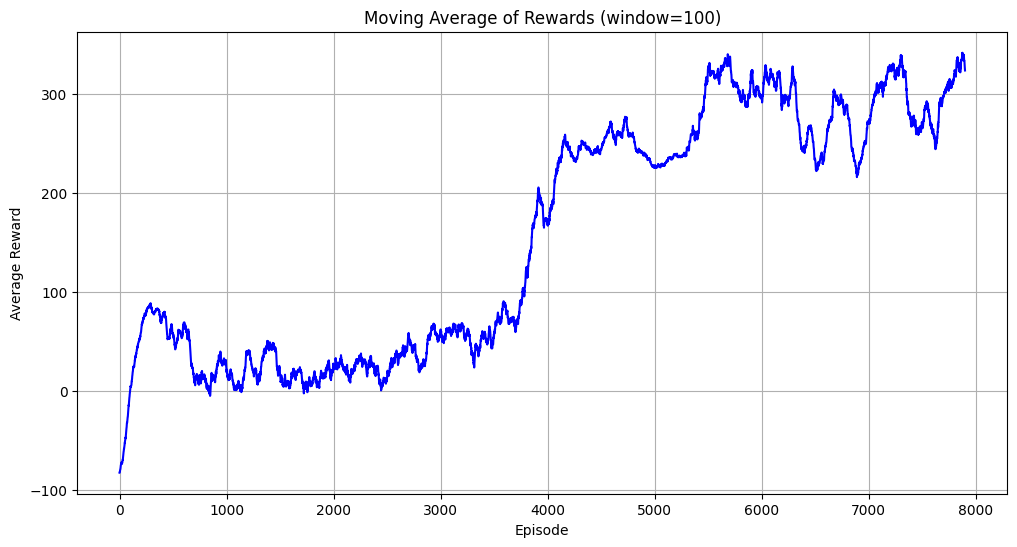

Finish Episode 0 with reward -149.0
Saved GIF: results/videos/mountain_car_episode_0.gif
Finish Episode 1 with reward -152.0
Saved GIF: results/videos/mountain_car_episode_1.gif
Finish Episode 2 with reward -200.0
Saved GIF: results/videos/mountain_car_episode_2.gif
Finish Episode 3 with reward -200.0
Saved GIF: results/videos/mountain_car_episode_3.gif
Finish Episode 4 with reward -159.0
Saved GIF: results/videos/mountain_car_episode_4.gif
Finish Episode 5 with reward -159.0
Saved GIF: results/videos/mountain_car_episode_5.gif
Finish Episode 6 with reward -152.0
Saved GIF: results/videos/mountain_car_episode_6.gif
Finish Episode 7 with reward -145.0
Saved GIF: results/videos/mountain_car_episode_7.gif
Finish Episode 8 with reward -140.0
Saved GIF: results/videos/mountain_car_episode_8.gif
Finish Episode 9 with reward -141.0
Saved GIF: results/videos/mountain_car_episode_9.gif
Finish Episode 10 with reward -140.0
Saved GIF: results/videos/mountain_car_episode_10.gif
Finish Episode 11 w

In [41]:

if __name__ == '__main__':

    mountaincar=Mountaincar()
    is_slippery=False
    mountaincar.train(8000, is_slippery)
    mountaincar.test(20,is_slippery)
